<a href="https://colab.research.google.com/github/miam-bonbon/assignment-computer-vision/blob/main/assignment_computer_vision_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit Detection with YOLOv5

My next step is to use YOLOv5 for the same task.

The goal is to improve for the task of object detection with the same dataset of fruits on a platter.

I set up the corresponding data (images and YOLOv5 formated labels) in Google Drive.

## Setting up the YOLOv5 environment

### Connect to Google Drive

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Install and start comet

We use [Comet ML](https://www.comet.com/site/) to track learning, parameters, predictions.
There are other similar tools available, but Comet ML is very convincing.

Comet ML has to be initialized before importing torch or other frameworks.

In [3]:
!pwd

/content


In [4]:
%cd /content/drive/MyDrive/assignment-computer-vision/
# !ls -l

/content/drive/MyDrive/assignment-computer-vision


In [5]:
%pip install comet_ml --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.9/709.9 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.8/981.8 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 13.9 MB/s eta 0:00:00


### Initialize Comet

We have to initialize and import before any references to torch

In [6]:
import comet_ml

from comet_ml import start
from comet_ml.integration.pytorch import log_model

comet_ml.login()
experiment = start(
  project_name="fruit-detection-yolov5",
  workspace="miam-bonbon"
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/miam-bonbon/fruit-detection-yolov5/109e8480a25d49a5a255563ada1d3bac



### Install ultralytics in our Colab environment:

In [7]:
!pip install torch torchvision torchaudio

COMET INFO: Couldn't find a Git repository in '/content/drive/MyDrive/assignment-computer-vision' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


In [8]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 51.4 MB/s eta 0:00:00


In [9]:
# %%capture

# # %load_ext autoreload
# # %autoreload 2
# import os
# import glob
# import random

# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import tqdm.auto as tqdm

# import tensorflow as tf

In [10]:
# import plot_functions

In [11]:
!nvidia-smi
# tf.config.list_physical_devices('GPU')

Fri Nov 29 16:40:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              51W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## Setting up the data

We already have our data set up in the right folders on Google Drive

In [12]:
!ls datasets/data_yolov5 -l

total 18160
-rw------- 1 root root      347 Nov 26 16:28 data.yaml
-rw------- 1 root root      148 Nov 26 13:01 README.dataset.txt
-rw------- 1 root root      990 Nov 26 13:01 README.roboflow.txt
drwx------ 2 root root     4096 Nov 26 13:14 test
drwx------ 2 root root     4096 Nov 26 13:14 train
drwx------ 2 root root     4096 Nov 26 13:14 valid
-rw------- 1 root root 18581255 Nov 26 14:01 yolov5su.pt


In [13]:
# We copy the whole datasets folder to the local environment for faster processing

!cp -r /content/drive/MyDrive/assignment-computer-vision/datasets /content/datasets

In [14]:
%cd /content
!ls -l

/content
total 12
drwx------ 3 root root 4096 Nov 29 16:40 datasets
drwx------ 6 root root 4096 Nov 29 16:40 drive
drwxr-xr-x 1 root root 4096 Nov 25 19:13 sample_data


In [15]:
# Disconnect google drive just to be sure

from google.colab import drive
drive.flush_and_unmount()

In [16]:
!ls -l

total 8
drwx------ 3 root root 4096 Nov 29 16:40 datasets
drwxr-xr-x 1 root root 4096 Nov 25 19:13 sample_data


## Data Inspection

### Class Distribution

We want to get a feel for the distribution of the labels in the prepared train, val and test folders

In [17]:
import os

# set up our data paths
base_path = 'datasets/data_yolov5'
train_image_dir = os.path.join(base_path, 'train')
validation_image_dir = os.path.join(base_path, 'valid')
test_image_dir = os.path.join(base_path, 'test')
yaml_config = os.path.join(base_path, 'data.yaml')

Processed train with 2205 images
Processed valid with 448 images
Processed test with 212 images


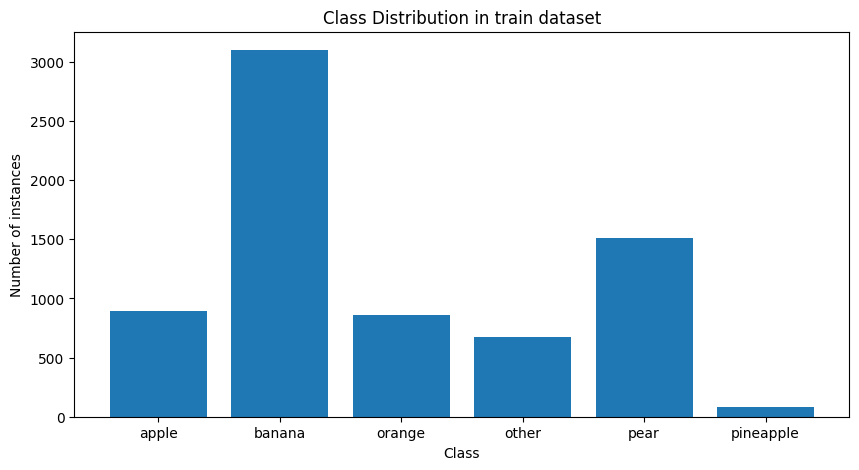

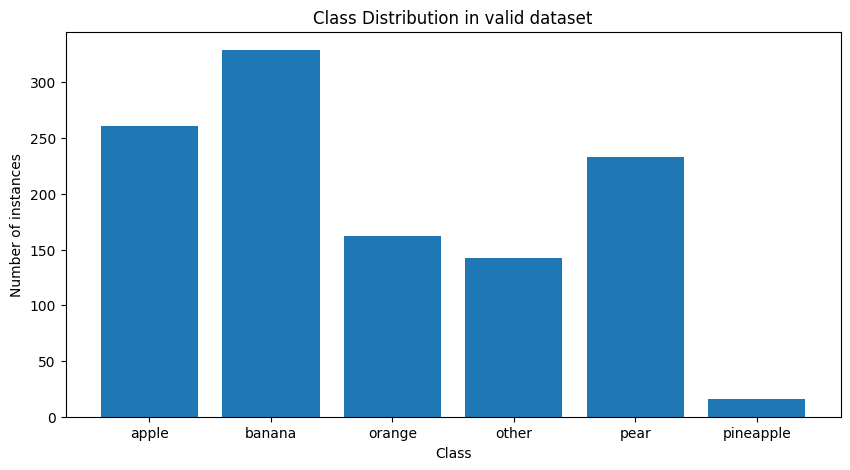

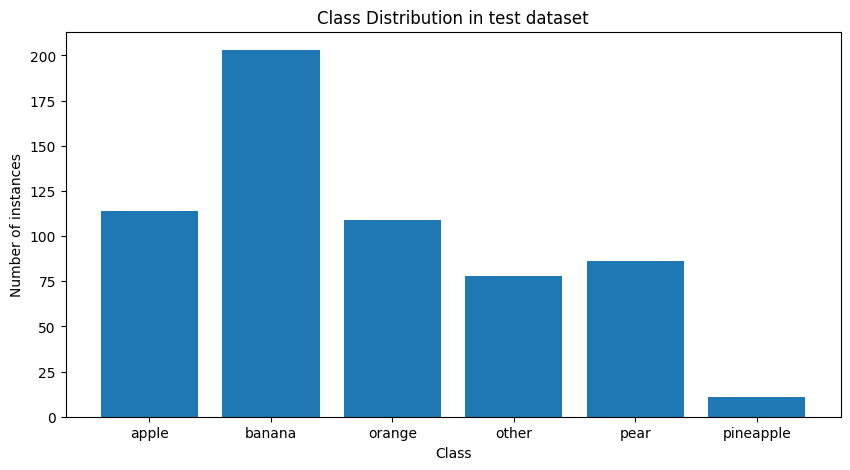

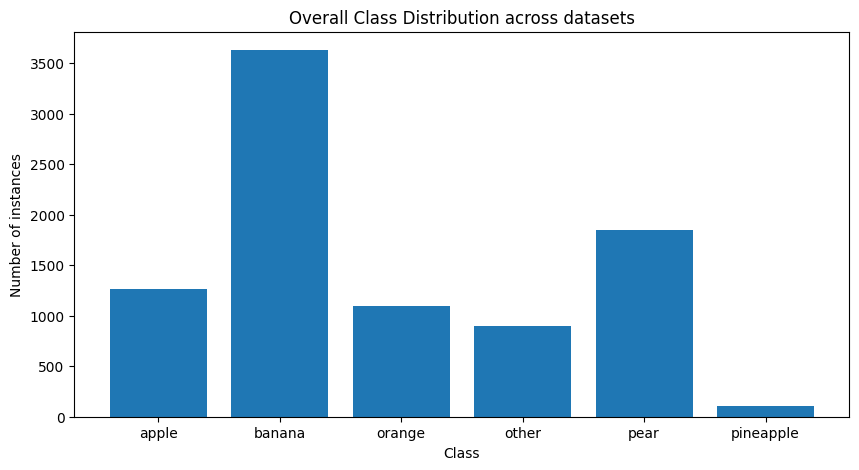

Total number of images: 2865


In [18]:
# Let's visualize data distribution over all datasets and for each dataset train validation and test

import os
import matplotlib.pyplot as plt
import pandas as pd

def visualize_data_distribution(base_path, classes=['apple', 'banana', 'orange', 'other', 'pear', 'pineapple']):
    """Visualizes the data distribution across datasets and splits."""
    splits = ["train", "valid", "test"]
    data = {}

    for split in splits:
        image_dir = os.path.join(base_path, split, 'images')
        # print(image_dir)
        label_dir = image_dir.replace('images', 'labels') #Assuming labels are in labels folder

        if os.path.exists(image_dir) and os.path.exists(label_dir):
          image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
          # print(image_files)
          num_images = len(image_files)

          class_counts = {}
          for label_file in [f for f in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, f))]:
              with open(os.path.join(label_dir, label_file), 'r') as f:
                  for line in f:
                      class_id = int(line.split()[0])
                      class_counts[class_id] = class_counts.get(class_id, 0) + 1

          data[split] = {
              "num_images": num_images,
              "class_counts": class_counts
          }
          print(f"Processed {split} with {num_images} images")
        else:
          print(f"Warning: {split} folder not found")

    #Plotting the class distributions
    for split in data:
      plt.figure(figsize=(10, 5))
      plt.bar(classes, data[split]['class_counts'].values())
      # plt.bar(data[split]['class_counts'].keys(), data[split]['class_counts'].values())
      plt.xlabel("Class")
      plt.ylabel("Number of instances")
      plt.title(f"Class Distribution in {split} dataset")
      plt.show()

    # Generate overall dataset summary
    overall_class_counts = {}
    total_images = 0
    for split in data:
      total_images += data[split]["num_images"]
      for class_id, count in data[split]["class_counts"].items():
          overall_class_counts[class_id] = overall_class_counts.get(class_id, 0) + count

    plt.figure(figsize=(10, 5))
    plt.bar(classes, overall_class_counts.values())
    plt.xlabel("Class")
    plt.ylabel("Number of instances")
    plt.title(f"Overall Class Distribution across datasets")
    plt.show()

    print(f"Total number of images: {total_images}")

visualize_data_distribution(base_path)

## Training

We have everything set up and can begin training

In [19]:
from ultralytics import YOLO

# let's evaluate with 5s
# model = YOLO('yolov5s.pt')
# and with 5m
model = YOLO('yolov5m.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PRO TIP 💡 Replace 'model=yolov5m.pt' with new 'model=yolov5mu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 48.2M/48.2M [00:01<00:00, 33.2MB/s]


In [20]:
# Check for config file
import os

config_file_path = yaml_config

if os.path.exists(config_file_path):
    print("config.yaml found at:", config_file_path)
else:
    print("config.yaml not found at:", config_file_path)

config.yaml found at: datasets/data_yolov5/data.yaml


In [21]:
# Train the model with Comet integration
results = model.train(
    data=yaml_config,
    batch=16,
    epochs=100,
    patience=10,
    device='cuda',
    cache=True,
    project='fruit-detection-yolov5',  # Comet project name
    name='fruit-detection-5m',  # Comet experiment name
    # verbose=True,
)

Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov5m.pt, data=datasets/data_yolov5/data.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=fruit-detection-yolov5, name=fruit-detection-5m, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fals

100%|██████████| 755k/755k [00:00<00:00, 132MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1      5280  ultralytics.nn.modules.conv.Conv             [3, 48, 6, 2, 2]              
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2     65280  ultralytics.nn.modules.block.C3              [96, 96, 2]                   
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    444672  ultralytics.nn.modules.block.C3              [192, 192, 4]                 
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  6   2512896  ultralytics.nn.modules.block.C3              [384, 384, 6]                 
  7                  -1  1   2655744  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 273MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/data_yolov5/train/labels... 2205 images, 3 backgrounds, 0 corrupt: 100%|██████████| 2205/2205 [00:01<00:00, 1179.64it/s]

train: New cache created: /content/datasets/data_yolov5/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (2.5GB RAM): 100%|██████████| 2205/2205 [00:00<00:00, 2487.89it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/data_yolov5/valid/labels... 448 images, 0 backgrounds, 0 corrupt: 100%|██████████| 448/448 [00:00<00:00, 979.58it/s]

val: New cache created: /content/datasets/data_yolov5/valid/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.5GB RAM): 100%|██████████| 448/448 [00:00<00:00, 952.20it/s]


Plotting labels to fruit-detection-yolov5/fruit-detection-5m/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 91 weight(decay=0.0), 98 weight(decay=0.0005), 97 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to fruit-detection-yolov5/fruit-detection-5m
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.02G     0.7668      1.107      1.107         72        640: 100%|██████████| 138/138 [00:21<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.80it/s]

                   all        448       1132      0.907      0.761      0.789      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.07G     0.7254     0.7052      1.084         67        640: 100%|██████████| 138/138 [00:18<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.27it/s]

                   all        448       1132      0.892      0.735      0.781      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.98G     0.7125     0.6528      1.082         70        640: 100%|██████████| 138/138 [00:17<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.06it/s]


                   all        448       1132      0.887      0.689      0.729      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.04G     0.6927     0.6286      1.074         88        640: 100%|██████████| 138/138 [00:17<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.24it/s]

                   all        448       1132      0.849      0.749      0.798      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.05G      0.663     0.5685      1.053         73        640: 100%|██████████| 138/138 [00:17<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.31it/s]

                   all        448       1132      0.946       0.75      0.786      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.07G     0.6356     0.5383      1.038         54        640: 100%|██████████| 138/138 [00:17<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.23it/s]

                   all        448       1132      0.928       0.79      0.809      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.05G     0.6308     0.5203      1.034         45        640: 100%|██████████| 138/138 [00:17<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.16it/s]

                   all        448       1132      0.941      0.806      0.818      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.08G     0.6142     0.4979      1.027         63        640: 100%|██████████| 138/138 [00:17<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.20it/s]

                   all        448       1132       0.96      0.787      0.812      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.05G     0.5891     0.4662      1.014         70        640: 100%|██████████| 138/138 [00:17<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.32it/s]

                   all        448       1132      0.931      0.766      0.801      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.08G     0.5875     0.4611      1.017         53        640: 100%|██████████| 138/138 [00:17<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.88it/s]

                   all        448       1132      0.942      0.796      0.811      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.06G      0.572     0.4502      1.008         72        640: 100%|██████████| 138/138 [00:17<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.40it/s]

                   all        448       1132      0.957      0.811      0.819      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.06G     0.5629     0.4463      1.007         53        640: 100%|██████████| 138/138 [00:17<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.30it/s]

                   all        448       1132       0.97      0.813      0.821      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.06G     0.5572     0.4266     0.9977         90        640: 100%|██████████| 138/138 [00:17<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.41it/s]

                   all        448       1132      0.958      0.813      0.816      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.07G      0.543     0.4279      0.992         75        640: 100%|██████████| 138/138 [00:17<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.36it/s]

                   all        448       1132      0.974       0.81      0.821      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.06G     0.5395     0.4185     0.9864         76        640: 100%|██████████| 138/138 [00:17<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.33it/s]

                   all        448       1132      0.977      0.815       0.82      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.07G     0.5166     0.4009     0.9809         78        640: 100%|██████████| 138/138 [00:17<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.09it/s]

                   all        448       1132       0.97      0.811      0.819      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.06G     0.5094     0.3859     0.9744         80        640: 100%|██████████| 138/138 [00:17<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.12it/s]

                   all        448       1132      0.959      0.804      0.821      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.07G      0.514     0.3845     0.9721         63        640: 100%|██████████| 138/138 [00:17<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.27it/s]

                   all        448       1132      0.961      0.814      0.817      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.07G     0.5066     0.3785     0.9748         82        640: 100%|██████████| 138/138 [00:17<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.33it/s]

                   all        448       1132       0.97      0.825      0.821      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.07G      0.492     0.3681     0.9685         76        640: 100%|██████████| 138/138 [00:17<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.34it/s]

                   all        448       1132      0.972      0.811      0.821      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.07G     0.4884     0.3631     0.9712         67        640: 100%|██████████| 138/138 [00:17<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.35it/s]

                   all        448       1132      0.978      0.814      0.822      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.07G      0.486     0.3586     0.9707         84        640: 100%|██████████| 138/138 [00:17<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.26it/s]

                   all        448       1132      0.973      0.823      0.821      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.05G      0.475     0.3525     0.9599         62        640: 100%|██████████| 138/138 [00:17<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.29it/s]

                   all        448       1132      0.968      0.814      0.821      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.07G     0.4757     0.3433       0.96         81        640: 100%|██████████| 138/138 [00:17<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.35it/s]

                   all        448       1132      0.962      0.815      0.819       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.06G     0.4686     0.3401     0.9564         71        640: 100%|██████████| 138/138 [00:17<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.38it/s]

                   all        448       1132      0.973      0.817      0.833      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.04G     0.4681     0.3403     0.9514         69        640: 100%|██████████| 138/138 [00:17<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.31it/s]

                   all        448       1132      0.962       0.82      0.814      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.06G     0.4637     0.3348     0.9511         61        640: 100%|██████████| 138/138 [00:17<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.32it/s]

                   all        448       1132      0.968      0.823      0.818      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.07G     0.4588     0.3342     0.9469         84        640: 100%|██████████| 138/138 [00:17<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.14it/s]

                   all        448       1132      0.973      0.822      0.819       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.06G     0.4438     0.3245     0.9448         83        640: 100%|██████████| 138/138 [00:17<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.33it/s]

                   all        448       1132      0.973      0.823      0.819      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.07G     0.4418     0.3188     0.9425         64        640: 100%|██████████| 138/138 [00:17<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.39it/s]

                   all        448       1132      0.966      0.819      0.814      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.07G     0.4316     0.3151      0.936         74        640: 100%|██████████| 138/138 [00:17<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.17it/s]

                   all        448       1132       0.97      0.819       0.82      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.06G      0.431     0.3076     0.9413         63        640: 100%|██████████| 138/138 [00:17<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.11it/s]

                   all        448       1132      0.972      0.818      0.818      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.07G     0.4291     0.3046     0.9374         91        640: 100%|██████████| 138/138 [00:17<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.42it/s]

                   all        448       1132      0.974      0.824      0.816      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.07G     0.4299     0.3074     0.9439         70        640: 100%|██████████| 138/138 [00:17<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.33it/s]

                   all        448       1132      0.807      0.823      0.819      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.06G     0.4201     0.2982     0.9332         80        640: 100%|██████████| 138/138 [00:17<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.34it/s]

                   all        448       1132       0.97       0.82      0.816      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.08G     0.4091     0.2917     0.9295         68        640: 100%|██████████| 138/138 [00:17<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.42it/s]

                   all        448       1132       0.98      0.821      0.823      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.07G     0.4063     0.2904     0.9303         58        640: 100%|██████████| 138/138 [00:17<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.32it/s]

                   all        448       1132      0.964      0.816       0.82      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.05G     0.4054     0.2899      0.925         82        640: 100%|██████████| 138/138 [00:17<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.26it/s]

                   all        448       1132      0.969      0.823      0.817       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.05G     0.3982     0.2832     0.9239         96        640: 100%|██████████| 138/138 [00:17<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.28it/s]

                   all        448       1132      0.945      0.806      0.811      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.07G     0.3973     0.2847     0.9263         46        640: 100%|██████████| 138/138 [00:17<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.35it/s]

                   all        448       1132      0.974      0.822      0.818      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.07G     0.3927     0.2802     0.9228         68        640: 100%|██████████| 138/138 [00:17<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.38it/s]

                   all        448       1132      0.974       0.82      0.819      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.08G     0.3844     0.2722     0.9134         89        640: 100%|██████████| 138/138 [00:17<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.30it/s]

                   all        448       1132      0.978      0.822      0.822      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.05G     0.3852     0.2736     0.9171         74        640: 100%|██████████| 138/138 [00:17<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.31it/s]

                   all        448       1132      0.978      0.821      0.825      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.08G     0.3772     0.2677     0.9145         75        640: 100%|██████████| 138/138 [00:17<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.32it/s]

                   all        448       1132      0.974      0.821      0.818      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.06G      0.377     0.2653     0.9096         64        640: 100%|██████████| 138/138 [00:17<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.26it/s]

                   all        448       1132      0.982      0.823      0.822      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.08G     0.3667     0.2619     0.9104         53        640: 100%|██████████| 138/138 [00:17<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.30it/s]

                   all        448       1132      0.979      0.822      0.822      0.725
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 36, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



46 epochs completed in 0.269 hours.
Optimizer stripped from fruit-detection-yolov5/fruit-detection-5m/weights/last.pt, 50.5MB
Optimizer stripped from fruit-detection-yolov5/fruit-detection-5m/weights/best.pt, 50.5MB

Validating fruit-detection-yolov5/fruit-detection-5m/weights/best.pt...
Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv5m summary (fused): 248 layers, 25,048,690 parameters, 0 gradients, 64.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.24it/s]


                   all        448       1132       0.98      0.821      0.823      0.727
                 apple        205        233       0.99      0.983      0.983      0.883
                banana        235        329      0.976          1      0.989      0.831
                orange        162        162      0.975          1      0.985      0.886
                 other         11         16          1          0     0.0263     0.0193
                  pear        140        141      0.971      0.949      0.966      0.876
             pineapple        251        251      0.968      0.996      0.988      0.865
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to fruit-detection-yolov5/fruit-detection-5m


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : conventional_cork_6991
COMET INFO:     url                   : https://www.comet.com/miam-bonbon/fruit-detection-yolov5/109e8480a25d49a5a255563ada1d3bac
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [635]                : (20697.583984375, 6432344.0)
COMET INFO:     lr/pg0 [93]               : (0.00033091787439613527, 0.0009778323671497586)
COMET INFO:     lr/pg1 [93]               : (0.00033091787439613527, 0.0009778323671497586)
COMET INFO:     lr/pg2 [93]               : (0.00033091787439613527, 0.0009778323671497586)
COMET INFO:     metrics/mAP50(B) [94]     : (0.72905, 0.8326)
COMET INFO:     metrics/mAP50-95(B) [94]  : (0.59218

We observe, a lot of important parameters are automatically handled for us:

```
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov5m.pt, data=datasets/data_yolov5/data.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=fruit-detection-yolov5, name=fruit-detection-5m, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=True, opset=None, workspace=None, nms=False, lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=7.5, cls=0.5, dfl=1.5, pose=12.0, kobj=1.0, nbs=64, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, bgr=0.0, mosaic=1.0, mixup=0.0, copy_paste=0.0, copy_paste_mode=flip, auto_augment=randaugment, erasing=0.4, crop_fraction=1.0, cfg=None, tracker=botsort.yaml, save_dir=fruit-detection-yolov5/fruit-detection-5m
```
These are the default parameters for training.

`Downloading https://ultralytics.com/assets/Arial.ttf to '/root/.config/Ultralytics/Arial.ttf'...`

Even the font can be parameterised

`Overriding model.yaml nc=80 with nc=6`

we have 6 classes

```
                   from  n    params  module                                       arguments                     
  0                  -1  1      5280  ultralytics.nn.modules.conv.Conv             [3, 48, 6, 2, 2]              
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2     65280  ultralytics.nn.modules.block.C3              [96, 96, 2]                   
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    444672  ultralytics.nn.modules.block.C3              [192, 192, 4]                 
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  6   2512896  ultralytics.nn.modules.block.C3              [384, 384, 6]                 
  7                  -1  1   2655744  ultralytics.nn.modules.conv.Conv             [384, 768, 3, 2]              
  8                  -1  2   4134912  ultralytics.nn.modules.block.C3              [768, 768, 2]                 
  9                  -1  1   1476864  ultralytics.nn.modules.block.SPPF            [768, 768, 5]                 
 10                  -1  1    295680  ultralytics.nn.modules.conv.Conv             [768, 384, 1, 1]              
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  2   1182720  ultralytics.nn.modules.block.C3              [768, 384, 2, False]          
 14                  -1  1     74112  ultralytics.nn.modules.conv.Conv             [384, 192, 1, 1]              
 15                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 16             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 17                  -1  2    296448  ultralytics.nn.modules.block.C3              [384, 192, 2, False]          
 18                  -1  1    332160  ultralytics.nn.modules.conv.Conv             [192, 192, 3, 2]              
 19            [-1, 14]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 20                  -1  2   1035264  ultralytics.nn.modules.block.C3              [384, 384, 2, False]          
 21                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
 22            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 23                  -1  2   4134912  ultralytics.nn.modules.block.C3              [768, 768, 2, False]          
 24        [17, 20, 23]  1   4221538  ultralytics.nn.modules.head.Detect           [6, [192, 384, 768]]          
YOLOv5m summary: 339 layers, 25,068,610 parameters, 25,068,594 gradients, 64.4 GFLOPs
```

This is our model - 339 layers, quite a bit bigger than our last one!


`Transferred 553/559 items from pretrained weights`

We use transfer learning here

`TensorBoard: Start with 'tensorboard --logdir fruit-detection-yolov5/fruit-detection-5m', view at http://localhost:6006/`

We can ignore tensorboard, since we're using Comet ML

`Freezing layer 'model.24.dfl.conv.weight'`

Again, transfer learning

```
`AMP: running   checks...
Downloading https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11n.pt to 'yolo11n.pt'...
100%|██████████| 5.35M/5.35M [00:00<00:00, 312MB/s]
AMP: checks passed ✅`
```

Automatic mixed precision (AMP) allows users to easily enable automatic mixed precision training enabling higher performance and memory savings of up to 50% on Tensor Core GPUs

```
train: Scanning /content/datasets/data_yolov5/train/labels... 2205 images, 3 backgrounds, 0 corrupt: 100%|██████████| 2205/2205 [00:01<00:00, 1159.82it/s]
train: New cache created: /content/datasets/data_yolov5/train/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.
train: Caching images (2.5GB RAM): 100%|██████████| 2205/2205 [00:00<00:00, 2381.41it/s]
```

For deterministic results we could consider cache='disk'

```
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
```

We even have albumentation working for us out of the box!

```
val: Scanning /content/datasets/data_yolov5/valid/labels... 448 images, 0 backgrounds, 0 corrupt: 100%|██████████| 448/448 [00:00<00:00, 907.78it/s]val: New cache created: /content/datasets/data_yolov5/valid/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.
val: Caching images (0.5GB RAM): 100%|██████████| 448/448 [00:00<00:00, 1657.84it/s]
```

This is preparing the training part.


```
Plotting labels to fruit-detection-yolov5/fruit-detection-5m/labels.jpg...
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically...
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 91 weight(decay=0.0), 98 weight(decay=0.0005), 97 bias(decay=0.0)
```
We have auto optimizer

`TensorBoard: model graph visualization added ✅`

Again, TensorBoard can be ignored

```
Image sizes 640 train, 640 val
Using 8 dataloader workers
```

Image size and workers

### Commisioning to Comet ML

To commision to Comet ML we have to close when finished

In [ ]:
# save to comet
experiment.end()